In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv("./Dataset/training_set_features.csv")
train_labels = pd.read_csv('./Dataset/training_set_labels.csv')
test = pd.read_csv('./Dataset/test_set_features.csv')
train = train.merge(train_labels, on='respondent_id')
train.head()


,respondent_id,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,xyz_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


## Feature engineering, selection,scaling


In [5]:
columns_to_drop = ["employment_occupation","employment_industry"]
train.drop(columns_to_drop,inplace=True,axis=1)
test.drop(columns_to_drop,inplace=True,axis=1)

train['preventive_behavior'] = (
    train['behavioral_antiviral_meds'] +
    train['behavioral_avoidance'] +
    train['behavioral_face_mask'] +
    train['behavioral_wash_hands'] +
    train['behavioral_large_gatherings'] +
    train['behavioral_outside_home'] +
    train['behavioral_touch_face']
)

train = train.drop(columns=[
    'behavioral_antiviral_meds',
    'behavioral_avoidance',
    'behavioral_face_mask',
    'behavioral_wash_hands',
    'behavioral_large_gatherings',
    'behavioral_outside_home',
    'behavioral_touch_face'
])

test['preventive_behavior'] = (
    test['behavioral_antiviral_meds'] +
    test['behavioral_avoidance'] +
    test['behavioral_face_mask'] +
    test['behavioral_wash_hands'] +
    test['behavioral_large_gatherings'] +
    test['behavioral_outside_home'] +
    test['behavioral_touch_face']
)

test = test.drop(columns=[
    'behavioral_antiviral_meds',
    'behavioral_avoidance',
    'behavioral_face_mask',
    'behavioral_wash_hands',
    'behavioral_large_gatherings',
    'behavioral_outside_home',
    'behavioral_touch_face'
])

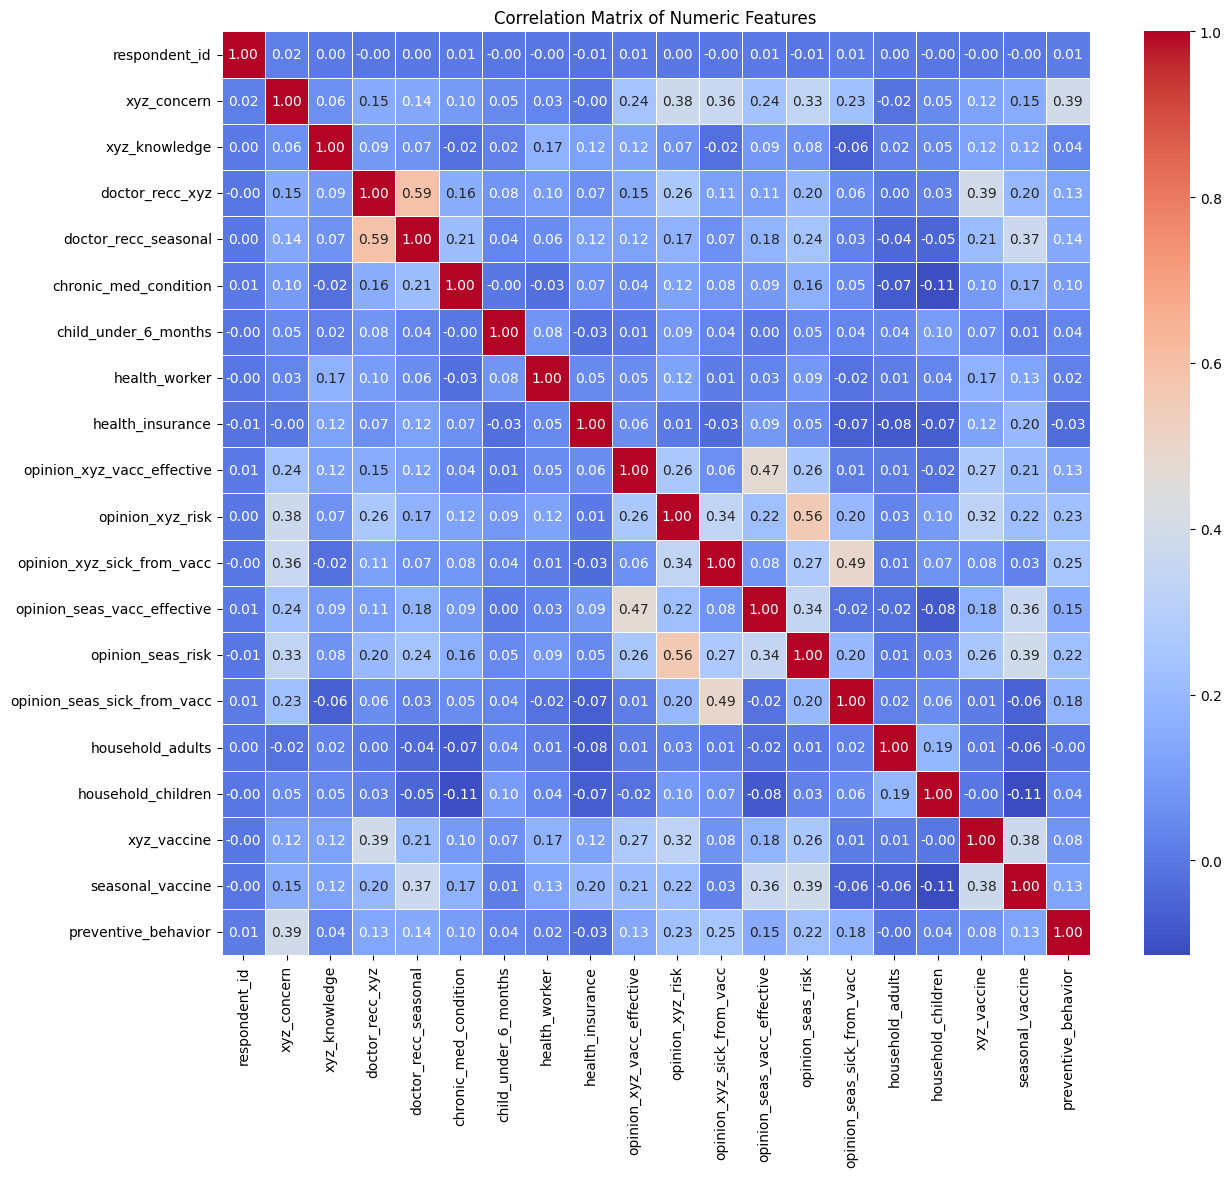

In [14]:
train.groupby(['hhs_geo_region'])['xyz_vaccine'].sum()#hmmmmm, it seems fairly normal except few values , might as well as keep it then
train.groupby(['census_msa'])['xyz_vaccine'].sum()# yup matters a lot :|
train.groupby(['marital_status'])['xyz_vaccine'].sum()# ehmmm
train.groupby(['rent_or_own'])['xyz_vaccine'].sum()# yup matters


df_numeric = train.select_dtypes(include=[np.number])
corr_matrix = df_numeric.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [17]:
test.shape
train.shape

(26708, 28)

## Training the models
- I will use mainly logistic regression as i am still in the process of learning about others 
- although i might try them 

In [18]:
from sklearn.impute import SimpleImputer

#respondent ids are just index so basically useless , and the other stuff is the one i need to predict
X = train.drop(columns=['respondent_id', 'xyz_vaccine', 'seasonal_vaccine']) 
y_xyz = train[['xyz_vaccine']].values
y_s = train[['seasonal_vaccine']].values

X_test = test.drop(columns=['respondent_id'])
#well i can use the median values , and code that myself but why reinvent the wheel, although i might try it :}
imputer = SimpleImputer(strategy='most_frequent')
X_i = imputer.fit_transform(X)
X_test_i = imputer.transform(X_test)
X_i = pd.DataFrame(X_i, columns=X.columns)
X_test_i = pd.DataFrame(X_test_i, columns=X_test.columns)


In [19]:
#time to replace these pesky little objects with numbers , i can use one hot encoding myself and its variations but as you know why re invent the wee-wee , might try it after hackathon
from sklearn.preprocessing import LabelEncoder

headings = {}
for column in X.columns:
    if X[column].dtype == 'object':
        l_encoder = LabelEncoder()
        X_i[column] = l_encoder.fit_transform(X_i[column])
        X_test_i[column] = l_encoder.transform(X_test_i[column])
        headings[column] = l_encoder

In [20]:
#everyone is equal , our model sholdn't give more importance to the rich members of the society just because they have more money it should see the pattern and adjust weight
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X_i)
X_test = scaler.transform(X_test_i)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lr_xyz = LogisticRegression(max_iter=5000)
lr_xyz.fit(X_i, y_xyz.ravel())

lr_seasonal = LogisticRegression(max_iter=5000)
lr_seasonal.fit(X_i, y_s.ravel())

roc_auc_xyz_lr = roc_auc_score(y_xyz, lr_xyz.predict_proba(X_i)[:, 1],average='macro')
roc_auc_seasonal_lr = roc_auc_score(y_s, lr_seasonal.predict_proba(X_i)[:, 1],average='macro')
print(f"ROC AUC in Logistic Regression {(roc_auc_xyz_lr+roc_auc_seasonal_lr )/2}")

xyz_vaccine_lr = lr_xyz.predict_proba(X_test_i)[:, 1] 
seasonal_vaccine_lr = lr_seasonal.predict_proba(X_test_i)[:, 1] 

ROC AUC in Logistic Regression 0.8380914272485234


In [24]:
#i am currently studying about these in more detail but sklearn can implement in seconds, bruhh, again i will try to do it from scratch , but it might take forever
from sklearn.naive_bayes import GaussianNB

gnb_xyz = GaussianNB()
gnb_seasonal = GaussianNB()

gnb_xyz.fit(X_i, y_xyz.ravel())
gnb_seasonal.fit(X_i, y_s.ravel())

roc_auc_xyz_gnb = roc_auc_score(y_xyz, gnb_xyz.predict_proba(X_i)[:, 1])
roc_auc_seasonal_gnb = roc_auc_score(y_s, gnb_seasonal.predict_proba(X_i)[:, 1]) 
print(f"ROC AUC in Guassian Naive Bias is {(roc_auc_xyz_gnb+roc_auc_seasonal_gnb)/2}")

xyz_vaccine_gnb = gnb_xyz.predict_proba(X_test_i)[:, 1]
seasonal_vaccine_gnb = gnb_seasonal.predict_proba(X_test_i)[:, 1]

#dammm it is not better than logistic regression

ROC AUC in Guassian Naive Bias is 0.800870775886822


In [25]:
from sklearn import svm

svm_xyz = svm.SVC(probability=True, kernel='rbf')
svm_seasonal = svm.SVC(probability=True, kernel='rbf')

svm_xyz.fit(X_i, y_xyz.ravel())
svm_seasonal.fit(X_i, y_s.ravel())

roc_auc_xyz_svm = roc_auc_score(y_xyz, svm_xyz.predict_proba(X_i)[:, 1])
roc_auc_seasonal_svm = roc_auc_score(y_s, svm_seasonal.predict_proba(X_i)[:, 1])
print(f"ROC AUC in SVM is {(roc_auc_xyz_svm+roc_auc_seasonal_svm)/2}")

xyz_vaccine_svm = svm_xyz.predict_proba(X_test_i)[:, 1]
seasonal_vaccine_svm = svm_seasonal.predict_proba(X_test_i)[:, 1]

ROC AUC in SVM is 0.8475029703421371


In [27]:
#svm is good
test_ids = test['respondent_id']
submission = pd.DataFrame({
    'respondent_id': test_ids,
    'xyz_vaccine': xyz_vaccine_lr,
    'seasonal_vaccine': seasonal_vaccine_lr
})
sub_svm = pd.DataFrame({
    'respondent_id': test_ids,
    'xyz_vaccine': xyz_vaccine_svm,
    'seasonal_vaccine': seasonal_vaccine_svm
})
submission.to_csv('submissionlr.csv', index=False)
sub_svm.to_csv('submissionsvm.csv', index=False)